In [1]:
# --- KOMÓRKA 0: PODŁĄCZ DYSK GOOGLE ---
from google.colab import drive
drive.mount('/content/drive')
print("Dysk Google podłączony.")

Mounted at /content/drive
Dysk Google podłączony.


In [2]:
# --- KOMÓRKA 1: BIBLIOTEKI ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
import time

# Ustawienia estetyczne wykresów
plt.style.use('seaborn-v0_8-darkgrid')
print("Biblioteki załadowane pomyślnie.")

Biblioteki załadowane pomyślnie.


In [3]:
# --- KOMÓRKA 2: WCZYTANIE DANYCH ---
# Sprawdzamy, czy mamy ścieżkę z poprzednich komórek, jeśli nie - używamy domyślnej
if 'OUTPUT_FILE' in locals():
    print(f"Wczytuję dane z: {OUTPUT_FILE}")
    df = pd.read_csv(OUTPUT_FILE)
else:
    path = '/content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv'
    print(f"Używam ścieżki awaryjnej: {path}")
    try:
        df = pd.read_csv(path)
        print("Dane wczytane poprawnie.")
    except FileNotFoundError:
        print("BŁĄD: Nie znaleziono pliku. Uruchom najpierw komórkę konfiguracyjną (tę pierwszą w całym notesie)!")
        df = pd.DataFrame()

Używam ścieżki awaryjnej: /content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv
Dane wczytane poprawnie.


In [4]:
# --- KOMÓRKA 3: INŻYNIERIA CECH ---
if not df.empty:
    print("Tworzę cechy fizyczne: Interakcja, Straty Cieplne, Lag...")

    # 1. INTERAKCJA (Moc = Moment * Prędkość) - BAZA
    df['inter_fr'] = df['setpoint_fr'] * df['speed_fr']
    df['inter_rl'] = df['setpoint_rl'] * df['speed_rl']
    df['inter_rr'] = df['setpoint_rr'] * df['speed_rr']

    # 2. STRATY CIEPLNE (Setpoint^2) - DODATEK 1
    df['heat_fr'] = df['setpoint_fr'] ** 2
    df['heat_rl'] = df['setpoint_rl'] ** 2
    df['heat_rr'] = df['setpoint_rr'] ** 2

    # 3. LAG (Opóźnienie) - DODATEK 2
    # Suma setpointów przesunięta o 1 krok w tył
    df['total_setpoint'] = df['setpoint_fr'] + df['setpoint_rl'] + df['setpoint_rr']
    df['lag_setpoint'] = df['total_setpoint'].shift(1).fillna(0)

    # 4. PODSTAWA DYNAMIKI (Niezbędne dla szeregów czasowych)
    # Przyspieszenie
    df['acc_fr'] = df['speed_fr'].diff().fillna(0)
    df['acc_rl'] = df['speed_rl'].diff().fillna(0)
    df['acc_rr'] = df['speed_rr'].diff().fillna(0)

    # Wygładzanie (Rolling mean)
    df['roll_speed_fr'] = df['speed_fr'].rolling(window=5, min_periods=1).mean()
    df['roll_speed_rl'] = df['speed_rl'].rolling(window=5, min_periods=1).mean()
    df['roll_speed_rr'] = df['speed_rr'].rolling(window=5, min_periods=1).mean()

    # Usuwamy puste wiersze (powstałe przez shift/diff)
    df.dropna(inplace=True)
    print("Cechy dodane. Gotowe do podziału danych.")
else:
    print("Brak danych do przetworzenia.")

Tworzę cechy fizyczne: Interakcja, Straty Cieplne, Lag...
Cechy dodane. Gotowe do podziału danych.


In [5]:
# --- KOMÓRKA 4: PODZIAŁ DANYCH (CHRONOLOGICZNY) ---
if not df.empty:
    # Sortowanie nie jest konieczne, jeśli dane w CSV są już po kolei,
    # ale dla pewności można odkomentować linię poniżej (jeśli masz kolumnę czasu):
    # df = df.sort_values(by='timestamp_column')

    # Podział manualny na osi czasu (80% początek -> Trening, 20% koniec -> Test)
    train_size = int(len(df) * 0.8)

    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    X_train = train_df.drop(columns=['power'])
    y_train = train_df['power']

    X_test = test_df.drop(columns=['power'])
    y_test = test_df['power']

    print(f"Dane podzielone CHRONOLOGICZNIE.")
    print(f"Zbiór treningowy: {X_train.shape[0]} próbek (Początek okrążenia/wyścigu)")
    print(f"Zbiór testowy:    {X_test.shape[0]} próbek (Koniec okrążenia/wyścigu)")

Dane podzielone CHRONOLOGICZNIE.
Zbiór treningowy: 41441 próbek (Początek okrążenia/wyścigu)
Zbiór testowy:    10361 próbek (Koniec okrążenia/wyścigu)


In [6]:
# --- KOMÓRKA 5: TRENING (XGBoost) ---
# Definicja modelu XGBoost
model = xgb.XGBRegressor(
    n_estimators=500,        # Liczba drzew (XGBoost jest szybki, można dać więcej)
    learning_rate=0.05,      # Wolniejsza nauka = większa precyzja
    max_depth=6,             # Głębokość drzewa
    subsample=0.8,           # Używaj 80% danych do budowy każdego drzewa (zapobiega przeuczeniu)
    colsample_bytree=0.8,    # Używaj 80% cech dla każdego drzewa
    n_jobs=-1,               # Użyj wszystkich rdzeni procesora (bardzo szybkie)
    random_state=42
)

print(f"Rozpoczynam trening modelu XGBoost...")

# Używamy eval_set, aby monitorować błąd w trakcie nauki (zamiast validation_fraction)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50  # Wypisuj postęp co 50 drzew
)
print("Trening zakończony sukcesem!")

Rozpoczynam trening modelu XGBoost...
[0]	validation_0-rmse:1505462.38661	validation_1-rmse:1259111.89845
[50]	validation_0-rmse:223517.27435	validation_1-rmse:215291.13338
[100]	validation_0-rmse:173240.26308	validation_1-rmse:200276.48157
[150]	validation_0-rmse:165864.55247	validation_1-rmse:203440.48832
[200]	validation_0-rmse:159613.80522	validation_1-rmse:204221.36305
[250]	validation_0-rmse:153348.83677	validation_1-rmse:205631.50827
[300]	validation_0-rmse:148532.78683	validation_1-rmse:206498.18677
[350]	validation_0-rmse:143962.31337	validation_1-rmse:207606.73092
[400]	validation_0-rmse:139863.74651	validation_1-rmse:208972.06212
[450]	validation_0-rmse:136234.05145	validation_1-rmse:210128.34586
[499]	validation_0-rmse:132451.89958	validation_1-rmse:211859.35113
Trening zakończony sukcesem!


Generowanie predykcji...
Rozpoczynam test szybkości modelu XGBoost...
--------------------------------------------------
 RAPORT SZYBKOŚCI (XGBoost)
--------------------------------------------------
Liczba próbek testowych: 10361
Łączny czas obliczeń:    0.3027 s
Średni czas na próbkę:   0.0292 ms
Maksymalna częstotliwość:34223.75 Hz
--------------------------------------------------

 PEŁNY RAPORT WYNIKÓW MODELU (XGBoost)
R2 Score (Dopasowanie):       0.9743 (max 1.0)
RMSE (Błąd pierwiastkowy):    211859.34 W
MAE (Średni błąd):            114170.85 W
MedAE (Mediana błędu):        54614.75 W
--------------------------------------------------
MAPE (Średni błąd %):         15.22%


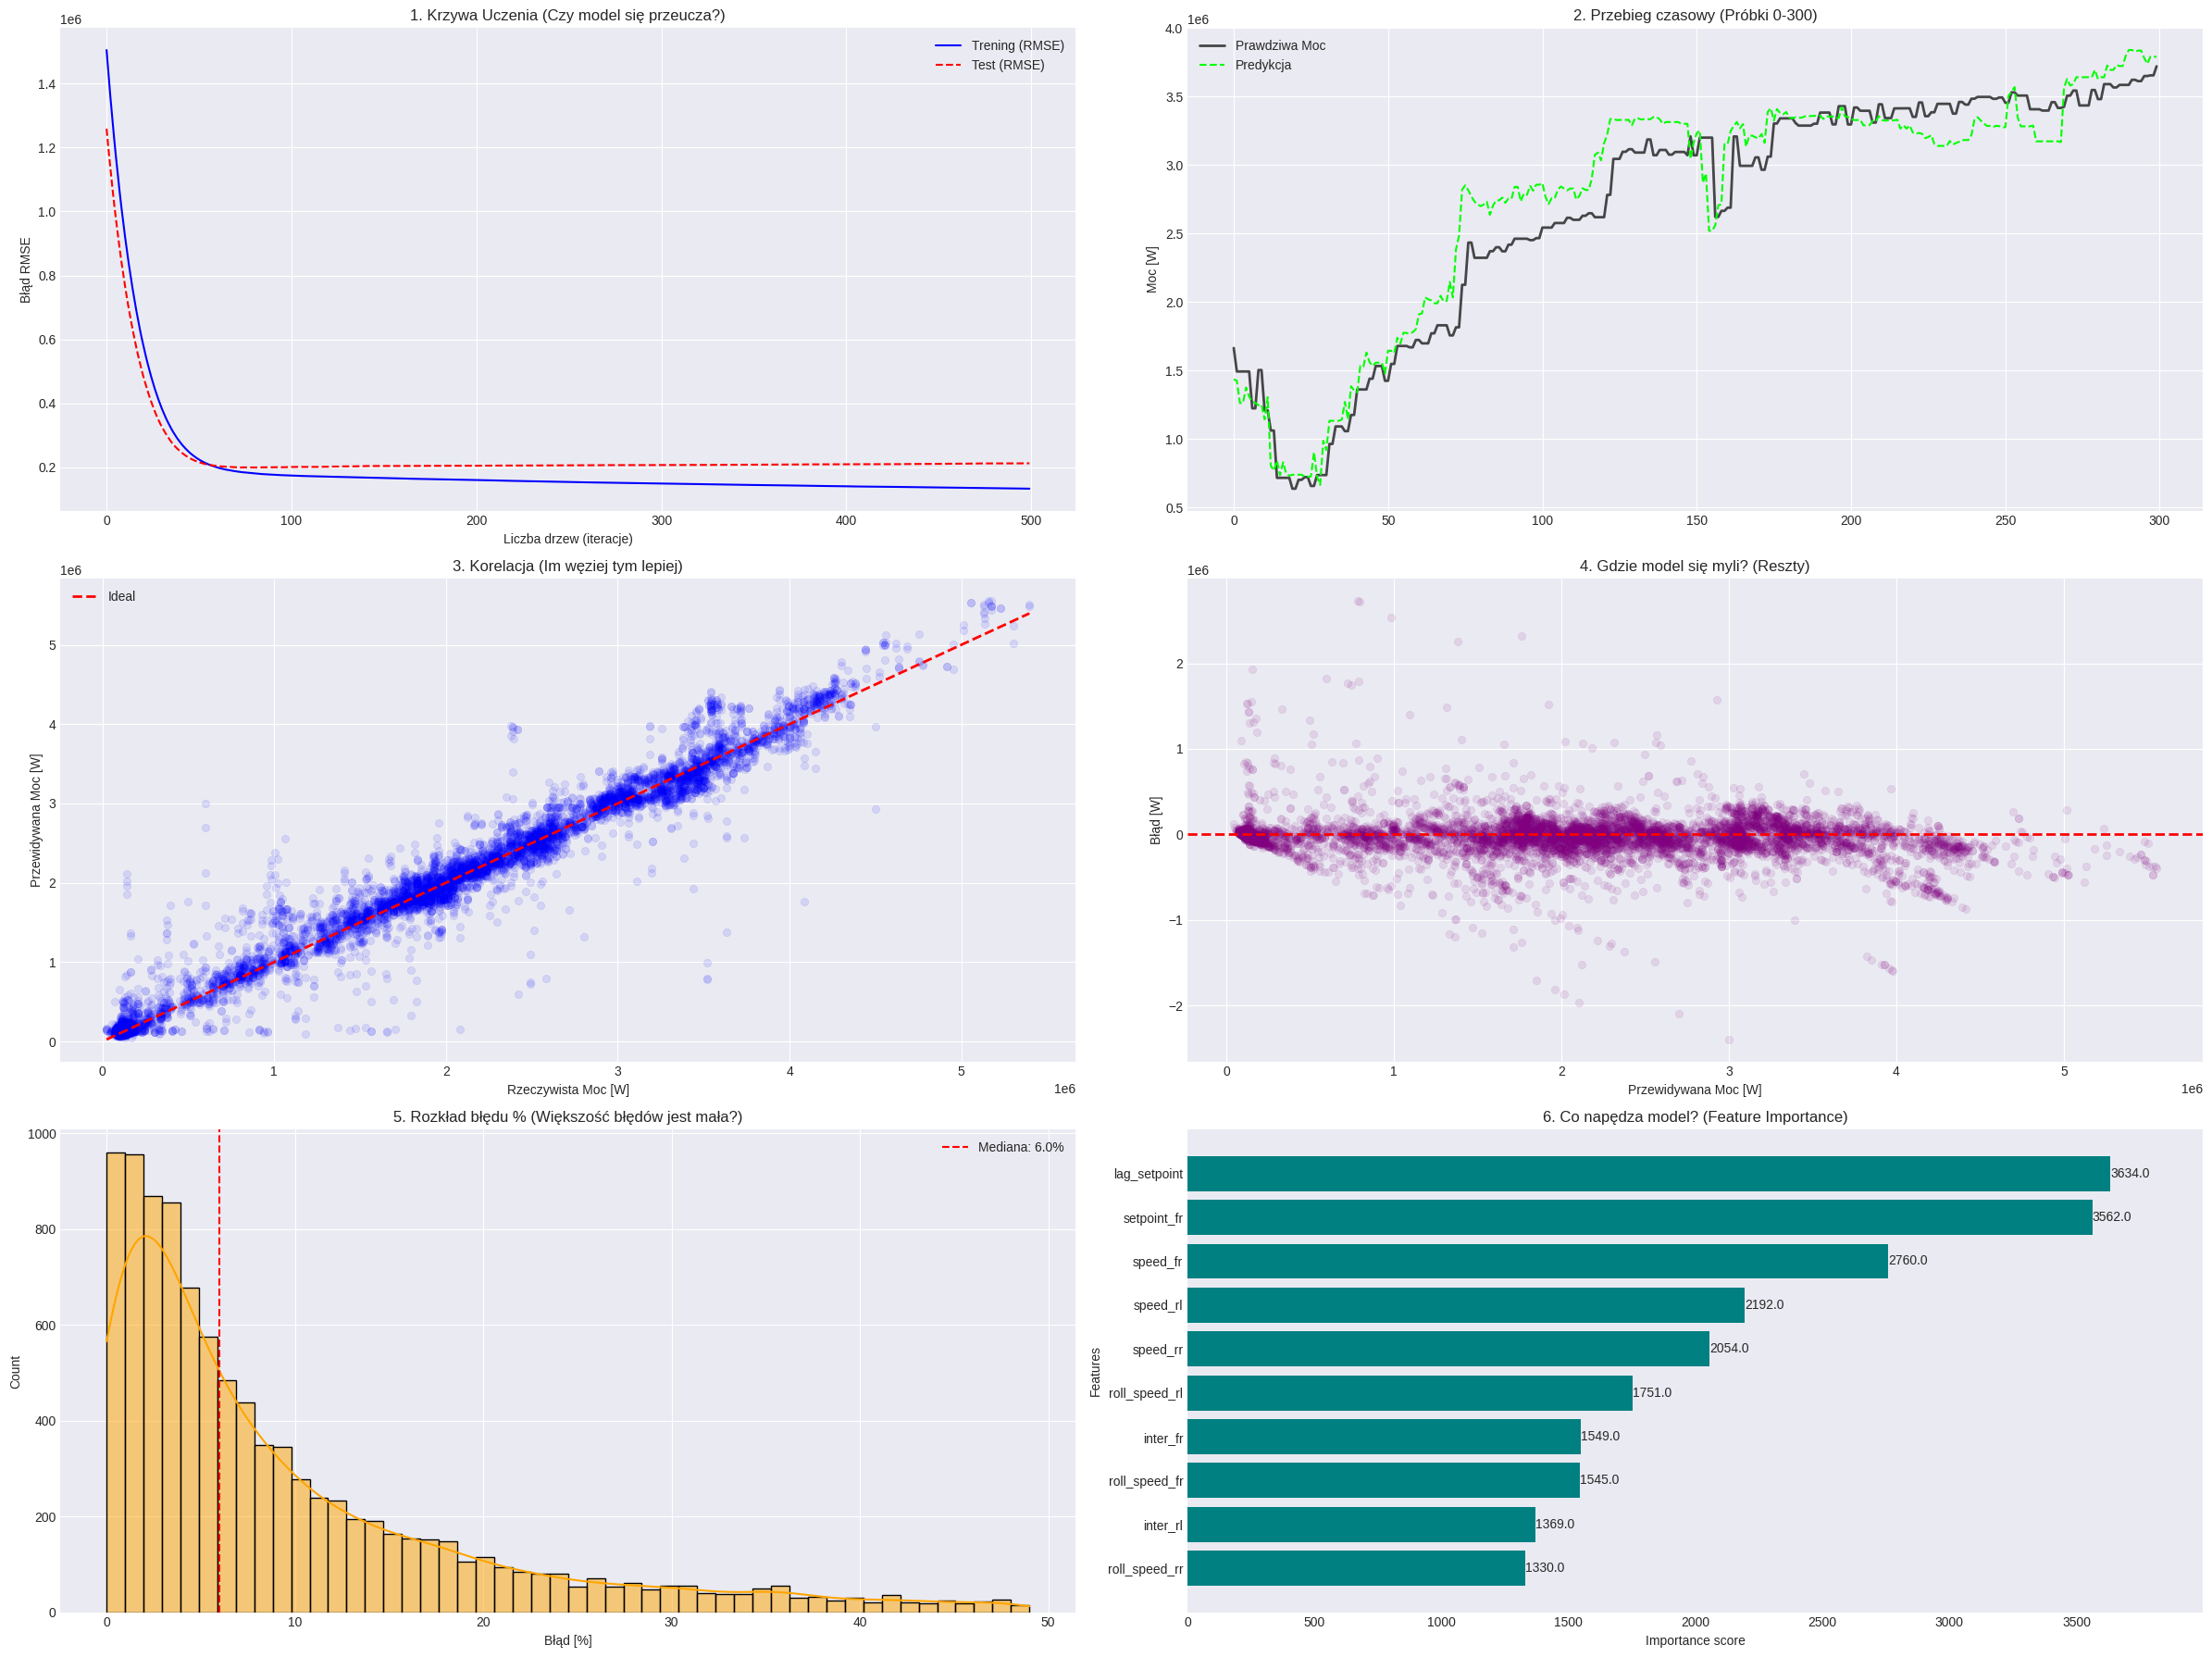

In [7]:
# --- KOMÓRKA 6: KOMPLETNA ANALIZA DLA XGBOOST ---
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Obliczenia predykcji
print("Generowanie predykcji...")
y_pred = model.predict(X_test)

# --- POMIAR CZASU PREDYKCJI (INFERENCE TIME) ---
print("Rozpoczynam test szybkości modelu XGBoost...")

# 1. Start stopera
start_time = time.time()

# 2. Wykonanie predykcji
# Mierzymy tylko sam moment obliczeń przez model
y_pred = model.predict(X_test)

# 3. Stop stopera
end_time = time.time()

# 4. Statystyki czasu
total_time = end_time - start_time
num_samples = len(X_test)
avg_time_per_sample = (total_time / num_samples) * 1000  # Konwersja na milisekundy (ms)

# Obliczenie teoretycznej częstotliwości (Hz)
frequency = 1000 / avg_time_per_sample if avg_time_per_sample > 0 else 0

print("-" * 50)
print(f" RAPORT SZYBKOŚCI (XGBoost)")
print("-" * 50)
print(f"Liczba próbek testowych: {num_samples}")
print(f"Łączny czas obliczeń:    {total_time:.4f} s")
print(f"Średni czas na próbkę:   {avg_time_per_sample:.4f} ms")
print(f"Maksymalna częstotliwość:{frequency:.2f} Hz")
print("-" * 50)


# 2. Obliczenia szczegółowych błędów
residuals = y_test - y_pred          # Reszty (różnica w Watach)
abs_errors = np.abs(residuals)       # Błąd bezwzględny

# Błąd procentowy (zabezpieczenie przed dzieleniem przez zero)
# Dla próbek gdzie moc=0, ustawiamy błąd na 0 lub pomijamy
pct_errors_per_sample = np.zeros_like(y_test)
mask = y_test != 0
pct_errors_per_sample[mask] = (abs_errors[mask] / np.abs(y_test[mask])) * 100

# 3. Metryki zbiorcze
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# MAPE liczony ręcznie, żeby uniknąć nieskończoności przy zerach
mape = np.mean(pct_errors_per_sample[mask])
medae = median_absolute_error(y_test, y_pred)

print("\n" + "="*50)
print(f" PEŁNY RAPORT WYNIKÓW MODELU (XGBoost)")
print("="*50)
print(f"R2 Score (Dopasowanie):       {r2:.4f} (max 1.0)")
print(f"RMSE (Błąd pierwiastkowy):    {rmse:.2f} W")
print(f"MAE (Średni błąd):            {mae:.2f} W")
print(f"MedAE (Mediana błędu):        {medae:.2f} W")
print("-" * 50)
print(f"MAPE (Średni błąd %):         {mape:.2f}%")
print("="*50)

# --- WIZUALIZACJA ---
fig, axes = plt.subplots(3, 2, figsize=(24, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# WYKRES 1: Krzywa Uczenia (XGBoost Specific)
# Pobieramy historię błędów zapisaną podczas treningu
results = model.evals_result()
# Sprawdzamy dostępne klucze (zazwyczaj validation_0 i validation_1)
if results:
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    axes[0, 0].plot(x_axis, results['validation_0']['rmse'], 'b-', label='Trening (RMSE)')
    axes[0, 0].plot(x_axis, results['validation_1']['rmse'], 'r--', label='Test (RMSE)')
    axes[0, 0].set_title('1. Krzywa Uczenia (Czy model się przeucza?)')
    axes[0, 0].set_ylabel('Błąd RMSE')
    axes[0, 0].set_xlabel('Liczba drzew (iteracje)')
    axes[0, 0].legend()
else:
    axes[0, 0].text(0.5, 0.5, 'Brak historii treningu (eval_set)', ha='center')

# WYKRES 2: Rzeczywistość vs Model (Zoom Czasowy)
# Pokazujemy fragment testowy (np. 200 próbek)
subset = 300
start_idx = 0 # Możesz zmienić, by przesunąć okno
axes[0, 1].plot(y_test.values[start_idx:start_idx+subset], label='Prawdziwa Moc', color='black', alpha=0.7, linewidth=2)
axes[0, 1].plot(y_pred[start_idx:start_idx+subset], label='Predykcja', color='lime', linestyle='--')
axes[0, 1].set_title(f'2. Przebieg czasowy (Próbki {start_idx}-{start_idx+subset})')
axes[0, 1].set_ylabel('Moc [W]')
axes[0, 1].legend()

# WYKRES 3: Scatter Plot (Idealne dopasowanie)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.1, ax=axes[1, 0], color='blue', edgecolor=None)
# Linia idealna y=x
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
axes[1, 0].set_title('3. Korelacja (Im węziej tym lepiej)')
axes[1, 0].set_xlabel('Rzeczywista Moc [W]')
axes[1, 0].set_ylabel('Przewidywana Moc [W]')
axes[1, 0].legend()

# WYKRES 4: Analiza Reszt
sns.scatterplot(x=y_pred, y=residuals, alpha=0.1, ax=axes[1, 1], color='purple', edgecolor=None)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 1].set_title('4. Gdzie model się myli? (Reszty)')
axes[1, 1].set_xlabel('Przewidywana Moc [W]')
axes[1, 1].set_ylabel('Błąd [W]')

# WYKRES 5: Histogram Błędów Procentowych
# Filtrujemy ekstremalne wartości dla czytelności wykresu
filtered_pct = pct_errors_per_sample[pct_errors_per_sample < 50]
sns.histplot(filtered_pct, bins=50, ax=axes[2, 0], color='orange', kde=True)
axes[2, 0].axvline(np.median(pct_errors_per_sample), color='red', linestyle='--', label=f'Mediana: {np.median(pct_errors_per_sample):.1f}%')
axes[2, 0].set_title('5. Rozkład błędu % (Większość błędów jest mała?)')
axes[2, 0].set_xlabel('Błąd [%]')
axes[2, 0].legend()

# WYKRES 6: Ważność Cech (XGBoost Native)
xgb.plot_importance(model, ax=axes[2, 1], height=0.8, importance_type='weight', max_num_features=10, color='teal', grid=False)
axes[2, 1].set_title('6. Co napędza model? (Feature Importance)')

plt.tight_layout()
plt.show()